In [1]:
from time import time
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter

device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')

# Loading data

Here, we import the data from the files. We have noticed that data already has been preprocessed, there is no need to lowercase the data, remove punctuation.

In [2]:
def load_file(dataset_type):
    """Reads the file and return the data as lists.
    Data already has been put in lowercase, without punctuation.
    No need to do it again.
    There are typos in the text"""
    text = []
    labels = []
    
    raw_data = open(f"data/{dataset_type}.txt").read().lower()
    
    for datapoint in raw_data.split('\n'):
        try:
            text_sample, label = datapoint.split(';')
            text.append(text_sample)
            labels.append(label)
        except ValueError:
            continue     
    return text, labels

# Construction of vocabulary

Here, we construct the vocabulary. We first compute the frequency of terms. We remove those that are extremly rare and that are useless for training, but that artificially increase the dimension of the data

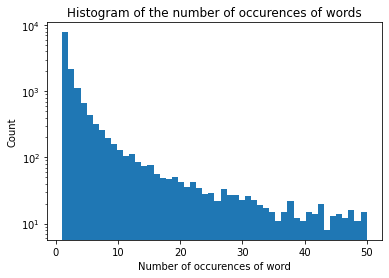

In [3]:
train_text, train_labels = load_file('train')
val_text, val_labels = load_file('val')
test_text, test_labels = load_file('test')

words_used = ' '.join(train_text).split(' ')
words_counts = dict(Counter(words_used))

plt.figure()
plt.hist(words_counts.values(), range=(1, 50), bins=50, log=True)
plt.xlabel("Number of occurences of word")
plt.ylabel("Count")
_ = plt.title("Histogram of the number of occurences of words")

In [4]:
# Words used 1 or 2 time are useless, we remove them
vocab = [k for (k,v) in words_counts.items() if 3 <= v <= 2000]

# Word for out of vocabulary
vocab_with_oov = vocab[:]
vocab_with_oov.append('oov')
print(f"Vocab_size : {len(vocab_with_oov)}")

Vocab_size : 5235


# Preprocessing of data

Now that we have built the vocabulary, we process the data. The dataset here is a list of sentences : each sentence is a point of the dataset, with a label associated among {'fear', 'anger', 'surprise', 'sadness', 'love', 'joy'}.

To process the data, we first extract the tokens. The sentence 'i love python and deep learning' becomes ['i', 'love', 'python', 'and', 'deep', 'learning']. The label associated for this sentence is 'love', for instance.

Then, each token is one hot encoded in the vocabulary. The representation becomes [ [0, ..., 1, 0 , ..., 0], ...] with the same number of internal list as of tokens in the previous representation.

Hence, a dataset is a 3 dimensionnal array of shape (dataset_length, sentence_length, vocabulary_size) : Each point of the dataset is a list of words, and each word is a list because the representation of words is one-hot encoding.

We then have a list of 6 tokens one hot encoded in the vocabulary.

In [5]:
def tokenize_text(text_dataset, sentence_length):
    """Converts a text dataset (list of strings) intro a list
    of short strings (tokens). For instance 'i am Superman'
    is converted in ['I', 'am', 'superman']."""
    processed_text = []
    for sentence in text_dataset:
        words = sentence.split(' ')
        words = [w if w in vocab else 'oov' for w in words]
        
        # If the sentence is too long, we crop it
        if len(words) > sentence_length:
            words = words[:sentence_length]
        
        # If the sentence is too short, we pad it with 'oov'
        if len(words) < sentence_length:
            pad_length = sentence_length - len(words)
            pad_with = ['oov' for _ in range(pad_length)]
            words.extend(pad_with)
        processed_text.append(words)
    return processed_text

In [6]:
convert_token_to_vector_dict = {k:v for v,k in enumerate(vocab_with_oov)}
util_matrix = np.eye(len(vocab_with_oov))  # To avoid recomputing the matrix each time.

def project_token(token):
    """Converts a token (a string) into a one hot
    representation."""
    return util_matrix[convert_token_to_vector_dict[token]]


def process_tokenized_text(tokenized_text):
    """Process a tokenized text (a list of list of tokens) into
    a list of lists of one-hot-representations of words (as a numpy array)."""
    result = []
    for sentence in tokenized_text:
        sentence = [project_token(token) for token in sentence]
        result.append(sentence)
    return torch.tensor(np.array(result, dtype=np.float32), device=device)

We have processed the text, but we haven't processed the labels yet. With the function below, we create a mapping of each label into {0, 1, ..., 5}.

In [7]:
# Labels are 'fear', 'anger', 'surprise', 'sadness', 'love', 'joy'
# Here, we convert them to values in {0, 1, ..., 5}

label_names = list(set(train_labels))
label_converter = {k:v for (v, k) in enumerate(label_names)}

def get_dense_labels(labels_list):
    """Converts a list of labels into a dense label in {0, ..., 5}."""
    dense_labels = [label_converter[label] for label in labels_list]
    return torch.tensor(np.array(dense_labels, dtype=np.int_), device=device, dtype=torch.long)

In [8]:
def get_dataset(dataset_type, sentence_length):
    text, labels = load_file(dataset_type)
    dataset = process_tokenized_text(tokenize_text(text, sentence_length))
    dense_labels = get_dense_labels(labels)

    return dataset, dense_labels

# Model initialization

We then initialize the model, a RNN but handcoded. We add an embedding layer from the Pytorch tutorial, given that we have a word-level RNN and not a character-level RNN, and that the dimension of the input would make in untractable to learn with such an high-dimensionnal recurrent layer.

In [9]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, emb_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2e = nn.Linear(input_size, emb_size)
        self.e2h = nn.Linear(emb_size + hidden_size, hidden_size)
        self.e2o = nn.Linear(emb_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        emb = F.relu(self.i2e(input))
        combined = torch.cat((emb, hidden), 1)
        hidden = F.relu(self.e2h(combined))
        output = self.e2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(
            batch_size,
            self.hidden_size,
            dtype=torch.float32,
            requires_grad=True
        )

# Training

In [10]:
def train_for_one_epoch(rnn, train_dataloader, val_dataloader, sentence_length, batch_size, criterion, optim):
    train_loss = 0
    train_acc = 0

    for dataset_batch, labels_batch in train_dataloader: 
        hidden = rnn.initHidden(batch_size)

        for word_index in range(sentence_length):
            word_batch = dataset_batch[:, word_index, :]
            output, hidden = rnn(word_batch, hidden)

        loss = criterion(output, labels_batch)
        loss.backward(retain_graph=True)

        # We accumulate the loss values
        train_loss += loss.item()

        # We count the number of correct predictions
        train_acc += (torch.argmax(output, 1) == labels_batch).sum().item() / batch_size

        # We update the weights
        #torch.nn.utils.clip_grad_norm_(rnn.parameters(), 0.9)
        optim.step()
        optim.zero_grad()


    num_batches = len(train_dataloader)
    train_loss /= num_batches  # To compute the mean over batches
    train_acc /= num_batches  # To compute the mean over batches
    
    # Eval phase
    val_loss = 0
    val_acc = 0
    
    for dataset_batch, labels_batch in val_dataloader:
        hidden = rnn.initHidden(batch_size)
        
        # Forward pass : prediction
        with torch.no_grad():
            for word_index in range(sentence_length):
                word_batch = dataset_batch[:, word_index, :]
                output, hidden = rnn(word_batch, hidden)


            # We accumulate the loss values
            val_loss += criterion(output, labels_batch).item()

            # We count the number of correct predictions
            val_acc += (torch.argmax(output, 1) == labels_batch).sum().item() / batch_size

    num_batches = len(val_dataloader)
    val_loss /= num_batches  # To compute the mean over batches
    val_acc /= num_batches  # To compute the mean over batches
    
    return train_loss, train_acc, val_loss, val_acc

In [11]:
num_epochs = 25
learning_rate = 1e-2
batch_size = 32
sentence_length = 12

input_size = len(vocab_with_oov)
hidden_size = 128
emb_size = 16
output_size = len(label_names)  # output_size = 6

rnn = RNN(input_size, hidden_size, emb_size, output_size)
criterion = nn.NLLLoss()
optim = torch.optim.RMSprop(rnn.parameters(), lr=learning_rate, weight_decay=1e-4)

train_dataset, train_labels = get_dataset('train', sentence_length)
val_dataset, val_labels = get_dataset('val', sentence_length)
test_dataset, test_labels = get_dataset('test', sentence_length)

train_dataset_tuple = TensorDataset(train_dataset, train_labels)
train_dataloader = DataLoader(train_dataset_tuple, batch_size, shuffle=True, drop_last=True)

val_dataset_tuple = TensorDataset(val_dataset, val_labels)
val_dataloader = DataLoader(val_dataset_tuple, batch_size, shuffle=True, drop_last=True)

writer = SummaryWriter()

for epoch in range(1, num_epochs+1):
    tic = time()
    
    train_loss, train_acc, val_loss, val_acc = train_for_one_epoch(
        rnn, train_dataloader, val_dataloader, sentence_length, batch_size, criterion, optim
    )  

    toc = time()

    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Accuracy/val', val_acc, epoch)

    print(f"Epoch n°{epoch}/{num_epochs} - Elapsed time : {toc-tic:.1f}s ")
    print(f"Train loss : {train_loss:.2f}\t-\tVal loss : {val_loss:.2f}")
    print(f"Train acc : {train_acc:.2f}\t-\tVal acc : {val_acc:.2f}")
    print("=========================================\n")

Epoch n°1/25 - Elapsed time : 9.6s 
Train loss : 1603.19	-	Val loss : 1.58
Train acc : 0.33	-	Val acc : 0.36

Epoch n°2/25 - Elapsed time : 10.0s 
Train loss : 1.63	-	Val loss : 1.46
Train acc : 0.38	-	Val acc : 0.47

Epoch n°3/25 - Elapsed time : 9.7s 
Train loss : 1.29	-	Val loss : 1.22
Train acc : 0.53	-	Val acc : 0.58

Epoch n°4/25 - Elapsed time : 7.9s 
Train loss : 1.07	-	Val loss : 1.04
Train acc : 0.61	-	Val acc : 0.60

Epoch n°5/25 - Elapsed time : 7.9s 
Train loss : 0.95	-	Val loss : 1.03
Train acc : 0.65	-	Val acc : 0.62

Epoch n°6/25 - Elapsed time : 9.2s 
Train loss : 0.87	-	Val loss : 0.91
Train acc : 0.70	-	Val acc : 0.71

Epoch n°7/25 - Elapsed time : 9.1s 
Train loss : 0.77	-	Val loss : 0.77
Train acc : 0.74	-	Val acc : 0.72

Epoch n°8/25 - Elapsed time : 11.0s 
Train loss : 0.76	-	Val loss : 0.79
Train acc : 0.74	-	Val acc : 0.72

Epoch n°9/25 - Elapsed time : 9.9s 
Train loss : 0.74	-	Val loss : 0.75
Train acc : 0.75	-	Val acc : 0.73

Epoch n°10/25 - Elapsed time : 1

# Hyperparameters optimization

This part allows us to optimize the hyperparameters. We just have to set our prior on the range of values for each hyperparameter, and the optuna framework allows us to search for optimal hyperparameters.

In [ ]:
import optuna

num_epochs = 15
learning_rate = 1e-2
batch_size = 32

input_size = len(vocab_with_oov)
hidden_size = 32
emb_size = 8

input_size = len(vocab_with_oov)
output_size = len(label_names)  # output_size = 6


train_dataset, train_labels = get_dataset('train', sentence_length)
val_dataset, val_labels = get_dataset('val', sentence_length)

train_dataset_tuple = TensorDataset(train_dataset, train_labels)
train_dataloader = DataLoader(train_dataset_tuple, batch_size, shuffle=True, drop_last=True)

val_dataset_tuple = TensorDataset(val_dataset, val_labels)
val_dataloader = DataLoader(val_dataset_tuple, batch_size, shuffle=True, drop_last=True)

criterion = nn.NLLLoss()
optim = torch.optim.RMSprop(rnn.parameters(), lr=learning_rate, weight_decay=3e-4)


def job(trial):
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-2, log=True)
    hidden_size = trial.suggest_int("hidden_size", 16, 256, log=True)
    emb_size = trial.suggest_int("emb_size", 4, 32, log=True)
    
    rnn = RNN(input_size, hidden_size, emb_size, output_size)
    
    val_acc_hist = []
    
    for epoch in range(1, num_epochs+1):
        _, _, _, val_acc = train_for_one_epoch(
            rnn, train_dataloader, val_dataloader, sentence_length, batch_size, criterion, optim
        )
        val_acc_hist.append(val_acc)
    return max(val_acc_hist)


study = optuna.create_study(direction='maximize')
study.optimize(job, n_trials=50, show_progress_bar=True)
print(study.best_params)

# Training over train and val, final evaluation on test

In this part, we merge both train and val dataset, and we then train on this dataset, and evaluate on test dataset.

In [ ]:
num_epochs = 20
learning_rate = 1e-2
batch_size = 32
sentence_length = 12

input_size = len(vocab_with_oov)
hidden_size = 128
emb_size = 16
output_size = len(label_names)  # output_size = 6

rnn = RNN(input_size, hidden_size, emb_size, output_size)
criterion = nn.NLLLoss()
optim = torch.optim.RMSprop(rnn.parameters(), lr=learning_rate, weight_decay=3e-4)

train_dataset, train_labels = get_dataset('train', sentence_length)
val_dataset, val_labels = get_dataset('val', sentence_length)
test_dataset, test_labels = get_dataset('test', sentence_length)

train_and_val_dataset = torch.cat((train_dataset, val_dataset))
train_and_val_labels = torch.cat((train_labels, val_labels))

train_and_val_dataset_tuple = TensorDataset(train_and_val_dataset, train_and_val_labels)
train_and_val_dataloader = DataLoader(train_and_val_dataset_tuple, batch_size, shuffle=True, drop_last=True)

test_dataset_tuple = TensorDataset(test_dataset, val_labels)
test_dataloader = DataLoader(test_dataset_tuple, batch_size, shuffle=True, drop_last=True)

writer = SummaryWriter()

for epoch in range(1, num_epochs+1):
    tic = time()
    
    train_loss, train_acc, val_loss, val_acc = train_for_one_epoch(
        rnn, train_dataloader, val_dataloader, sentence_length, batch_size, criterion, optim
    )  

    toc = time()

    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Accuracy/val', val_acc, epoch)

    print(f"Epoch n°{epoch}/{num_epochs} - Elapsed time : {toc-tic:.1f}s ")
    print(f"Train and val loss : {train_loss:.2f}\t-\tTest loss : {val_loss:.2f}")
    print(f"Train and val acc : {train_acc:.2f}\t-\tTest acc : {val_acc:.2f}")
    print("=========================================\n")

# Confusion matrix

In this part, we plot the confusion matrix, to localize where the model makes incorrect predictions.

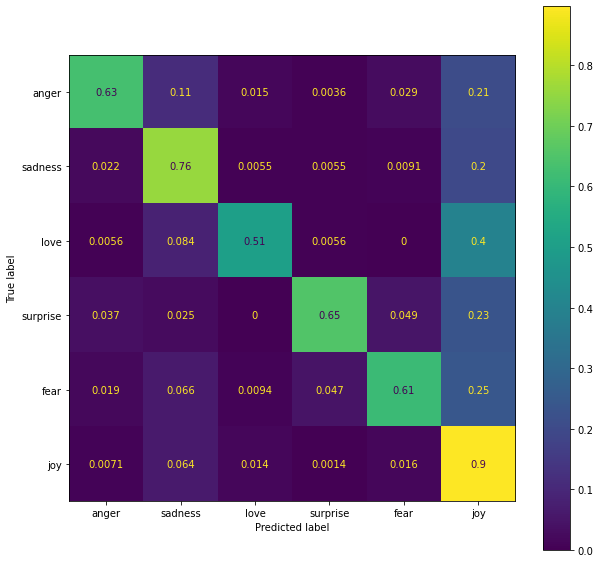

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def get_val_labels(rnn, val_dataset_tuple):
    batch_size = len(val_dataset_tuple)
    val_dataloader = DataLoader(val_dataset_tuple, batch_size, shuffle=True, drop_last=True)
    
    y_verite_terrain = []
    y_pred=[]
    
    rnn.eval()

    for dataset_batch, labels_batch in val_dataloader:
        hidden = rnn.initHidden(batch_size)

        # Forward pass : prediction
        with torch.no_grad():

            for word_index in range(sentence_length):
                word_batch = dataset_batch[:, word_index, :]
                output, hidden = rnn(word_batch, hidden)

            y_pred = torch.argmax(output, 1).tolist()
            y_verite_terrain = labels_batch.tolist()
    
    y_pred_labels = [label_names[x] for x in y_pred]
    y_verite_terrain_labels = [label_names[x] for x in y_verite_terrain]
    return y_verite_terrain_labels,y_pred_labels

y_true, y_pred = get_val_labels(rnn, val_dataset_tuple)

cm = confusion_matrix(y_true, y_pred, labels=[v for v in label_names])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[v for v in label_names])
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.savefig('confusion_matrix_rnn.eps')
plt.show()